In [168]:
!pip install tabulate
!pip install folium
!pip install colorama
!pip install geopy
!pip install pyswarm

In [169]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import folium
from colorama import Fore, Style, init
from IPython.display import display
from geopy.distance import geodesic
from datetime import datetime

init()

# Print execution info
print(f"Execution Date and Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"User: kripa-sindhu-007\n")


Execution Date and Time: 2025-03-30 17:41:00
User: kripa-sindhu-007



In [170]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # kg
    "wheel_radius": 0.2848,  # meters
    "transmission_ratio": 5.763,
    "transmission_efficiency": 0.95,
    "drive_efficiency": 0.95,
    "a0": 125.73,  # N (rolling resistance)
    "a1": 1.72,    # N/(m/s)
    "a2": 0.58,    # N/(m/s)^2
    "motor_min_torque": -50,  # Nm
    "motor_max_torque": 200,  # Nm
    "acceleration": 1.5,  # m/s²
    "air_density": 1.225,  # kg/m³
    "gravity": 9.81,  # m/s²
    "battery_capacity": 100,  # kWh
    "initial_charge": np.random.uniform(40, 95),  # kWh (e.g., near 95% charge)
    "min_charge": 20,  # kWh (minimum desired battery level)
    "cost_per_kwh": 0.60,  # $ per kWh for charging
    "green_zone_penalty": 0.4  # $ penalty for not using green zones when possible
}

def compute_section_energy(length, speed, grade, vehicle_params, acceleration=0):
    """
    Compute energy consumption for a road section based on the De Nunzio model.

    Parameters:
        length (float): Road section length in meters.
        speed (float): Speed in m/s.
        grade (float): Road grade (e.g., 0.03 for 3%).
        vehicle_params (dict): Vehicle parameters.
        acceleration (float): Acceleration in m/s².

    Returns:
        float: Energy consumption in kWh.
    """
    if speed <= 0:
        return 0

    # Calculate forces
    rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
    slope_force = vehicle_params["mass"] * vehicle_params["gravity"] * grade
    inertial_force = vehicle_params["mass"] * acceleration

    total_force = rolling_force + slope_force + inertial_force

    # Motor torque calculation
    wheel_radius = vehicle_params["wheel_radius"]
    transmission_ratio = vehicle_params["transmission_ratio"]
    transmission_efficiency = vehicle_params["transmission_efficiency"]

    if total_force >= 0:
        motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
    else:
        motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio

    motor_torque = max(vehicle_params["motor_min_torque"],
                       min(vehicle_params["motor_max_torque"], motor_torque))

    # Power and energy calculations
    motor_speed = speed * transmission_ratio / wheel_radius
    motor_power = motor_torque * motor_speed

    drive_efficiency = vehicle_params["drive_efficiency"]
    battery_power = (motor_power / drive_efficiency) if motor_power >= 0 else (motor_power * drive_efficiency)

    travel_time = length / speed  # in seconds
    energy_joules = battery_power * travel_time
    energy_kwh = energy_joules / 3600000  # Convert Joules to kWh

    return energy_kwh


In [171]:
def calculate_route_costs(path, graph, vehicle_params, charging_stations_used=None, algorithm_type=None):
    """
    Computes route metrics (energy, time, cost, etc.) for a given path.

    Parameters:
      path (list): List of node IDs representing the route.
      graph (nx.Graph): Road network graph with edge attributes.
      vehicle_params (dict): Dictionary of vehicle parameters.
      charging_stations_used (list, optional): List of charging station nodes visited on the route.
      algorithm_type (str, optional): One of ['heuristic', 'eco', 'shortest', 'fastest'].

    Returns:
      dict: Metrics including:
             - distance: total distance traveled,
             - time: total travel time (including charging/waiting),
             - energy: total energy consumed,
             - energy_cost: cost of energy consumed,
             - running_cost: additional running costs,
             - charging_cost: cost incurred while charging,
             - v2g_incentives: monetary credit for V2G discharge (only for heuristic),
             - green_zone_penalties: penalties for non-green segments,
             - total_cost: composite cost,
             - remaining_charge: battery state at route’s end,
             - charging_stations_visited: list of charging stations encountered,
             - charging_time: total time spent charging/waiting.
    """
    total_distance = 0.0
    total_time = 0.0
    total_energy = 0.0
    energy_cost = 0.0
    running_cost = 0.0
    green_zone_penalties = 0.0
    remaining_charge = vehicle_params["initial_charge"]

    # Process each edge along the route.
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        edge = graph[u][v]
        edge_energy = edge['energy']
        if algorithm_type == 'heuristic':
            # Apply a 10% modifier: if positive, reduce by 10%; if negative, increase by 10%.
            edge_energy = edge_energy * 0.9 if edge_energy > 0 else edge_energy * 1.1
            # Further reduce energy consumption by 15% if the edge is in a green zone.
            if edge.get('in_green_zone', False):
                edge_energy *= 0.85
        total_energy += edge_energy
        remaining_charge -= edge_energy
        energy_cost += edge_energy * vehicle_params["cost_per_kwh"]
        total_time += edge['travel_time']
        total_distance += edge['length']
        # Accumulate green zone penalty for each edge that is not in a green zone.
        if not edge.get('in_green_zone', False):
            green_zone_penalties += vehicle_params["green_zone_penalty"]

    # Initialize charging and V2G variables.
    charging_cost = 0.0
    v2g_incentives = 0.0
    charging_time = 0.0
    waiting_time = 300  # Additional waiting time (seconds) per V2G event.

    if algorithm_type == 'heuristic':
        if charging_stations_used:
            current_charge = vehicle_params["initial_charge"]
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                edge = graph[u][v]
                edge_energy = edge['energy']
                edge_energy = edge_energy * 0.9 if edge_energy > 0 else edge_energy * 1.1
                if edge.get('in_green_zone', False):
                    edge_energy *= 0.85
                current_charge -= edge_energy

                if v in charging_stations_used:
                    station_node = graph.nodes[v]
                    energy_to_destination = 0.0
                    try:
                        start_index = path.index(v) + 1
                    except ValueError:
                        start_index = i + 1
                    for j in range(start_index, len(path) - 1):
                        p, q = path[j], path[j+1]
                        e_val = graph[p][q]['energy']
                        e_val = e_val * 0.9 if e_val > 0 else e_val * 1.1
                        if graph[p][q].get('in_green_zone', False):
                            e_val *= 0.85
                        energy_to_destination += e_val
                    required_energy = energy_to_destination * 1.1  # 10% safety buffer.
                    target_charge = min(required_energy + vehicle_params["min_charge"],
                                        vehicle_params["battery_capacity"] * 0.8) if required_energy else vehicle_params["min_charge"]

                    if current_charge < target_charge:
                        charge_amount = min(target_charge - current_charge,
                                            station_node.get('initial_charge', 40))
                        current_charge += charge_amount
                        charge_rate = station_node.get('charging_rate', 7)
                        station_charging_time = charge_amount / charge_rate
                        charging_time += station_charging_time
                        charging_cost += charge_amount * vehicle_params["cost_per_kwh"]
                    elif station_node.get('v2g_enabled', False) and current_charge > (target_charge + 5):
                        available_excess = current_charge - (target_charge + 5)
                        v2g_amount = min(available_excess * 0.3, 5)  # discharge 30% of available excess, capped at 5 kWh.
                        if v2g_amount > 0:
                            current_charge -= v2g_amount
                            incentive_rate = 1.2 * vehicle_params["cost_per_kwh"]
                            v2g_incentives += v2g_amount * incentive_rate
                            # Add waiting time for the V2G event.
                            charging_time += waiting_time
                            total_time += waiting_time
        else:
            if remaining_charge > (vehicle_params["min_charge"] + 5):
                available_excess = remaining_charge - (vehicle_params["min_charge"] + 5)
                v2g_amount = min(available_excess * 0.3, 5)
                if v2g_amount > 0:
                    remaining_charge -= v2g_amount
                    incentive_rate = 1.4 * vehicle_params["cost_per_kwh"]
                    v2g_incentives += v2g_amount * incentive_rate
                    total_time += waiting_time
    else:
        # For non-heuristic algorithms, do not apply V2G incentives. Use the computed green_zone_penalties.
        v2g_incentives = 0

    total_cost = energy_cost + running_cost + charging_cost - v2g_incentives + green_zone_penalties

    metrics = {
        "distance": total_distance,
        "time": total_time + charging_time,
        "energy": total_energy,
        "energy_cost": energy_cost,
        "running_cost": running_cost,
        "charging_cost": charging_cost,
        "v2g_incentives": v2g_incentives,
        "green_zone_penalties": green_zone_penalties,
        "total_cost": total_cost,
        "remaining_charge": remaining_charge,
        "charging_stations_visited": charging_stations_used if charging_stations_used else [],
        "charging_time": charging_time
    }

    if remaining_charge < vehicle_params["min_charge"]:
        metrics["warning"] = "Battery might deplete before reaching destination"

    return metrics


In [172]:
def generate_road_network(num_nodes=400, num_edges=1200, seed=42, num_charging_stations=20):
    """
    Parameters:
        num_nodes (int): Number of nodes (intersections).
        num_edges (int): Number of edges (roads).
        seed (int): Random seed for reproducibility.
        num_charging_stations (int): Number of charging stations to add.

    Returns:
        nx.Graph: Road network graph with nodes, edges, and attributes.
    """
    np.random.seed(seed)
    random.seed(seed)

    grid_size = int(np.sqrt(num_nodes))
    road_network = nx.grid_2d_graph(grid_size, grid_size)
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic positions to nodes (simulate a city of 30km x 30km)
    city_size = 30000  # meters
    pos = {}
    for i in range(road_network.number_of_nodes()):
        row = i // grid_size
        col = i % grid_size
        jitter = np.random.normal(0, 200, 2)
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add charging stations to random nodes
    charging_station_nodes = random.sample(list(road_network.nodes()), num_charging_stations)
    for node in road_network.nodes():
        if node in charging_station_nodes:
            road_network.nodes[node]['charging_station'] = True
            road_network.nodes[node]['charging_capacity'] = 200  # kWh available
            road_network.nodes[node]['initial_charge'] = np.random.uniform(70, 100)
            road_network.nodes[node]['charging_rate'] = np.random.uniform(50, 150)  # kW
            road_network.nodes[node]['v2g_enabled'] = True
            road_network.nodes[node]['incentive_rate'] = 1  # $ per kWh for V2G
        else:
            road_network.nodes[node]['charging_station'] = False

    # Add additional random edges to reach desired number of edges
    existing_edges = len(road_network.edges())
    edges_to_add = max(0, num_edges - existing_edges)
    attempts = 0
    while len(road_network.edges()) < num_edges and attempts < edges_to_add * 3:
        attempts += 1
        node1, node2 = random.sample(list(road_network.nodes()), 2)
        if road_network.has_edge(node1, node2):
            continue
        pos1, pos2 = pos[node1], pos[node2]
        dist = np.sqrt((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)
        if dist > city_size/5:
            continue
        road_network.add_edge(node1, node2)

    # Set edge attributes (length, speed limit, travel time, energy, etc.)
    for u, v in road_network.edges():
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)
        road_network[u][v]['length'] = distance
        road_network[u][v]['traffic_density'] = np.random.normal(0.7, 0.2)
        road_network[u][v]['speed_limit'] = np.random.choice(
            [30, 40, 50, 60, 80],
            p=[0.2, 0.3, 0.3, 0.15, 0.05]
        ) * (1000 / 3600)  # Convert km/h to m/s
        road_network[u][v]['grade'] = 0  # flat road
        road_network[u][v]['travel_time'] = distance / road_network[u][v]['speed_limit']
        energy = compute_section_energy(
            distance,
            road_network[u][v]['speed_limit'],
            road_network[u][v]['grade'],
            VEHICLE_PARAMETERS
        )
        road_network[u][v]['energy'] = energy
        road_network[u][v]['energy_cost'] = max(0, energy) * 0.20  # $ per kWh cost for positive consumption
        road_network[u][v]['abs_energy'] = abs(energy)

        # Mark edge as a green zone edge with a 30% chance (this designates the road itself as "green")
        if np.random.rand() < 0.3:
            road_network[u][v]['in_green_zone'] = True
        else:
            road_network[u][v]['in_green_zone'] = False

    return road_network

# road_network = generate_road_network_modified(num_nodes=1000, num_edges=2000, num_charging_stations=60)


In [173]:
import random
import networkx as nx

def aco_routing_extreme_green_bias(
    graph, source, target, vehicle_params,
    num_ants=30, num_iterations=50,
    alpha=1.0, beta=4.0, evaporation_rate=0.1,
    green_bonus=20.0
):

    # Initialize pheromone for each edge
    pheromone = {}
    for u, v in graph.edges():
        pheromone[(u, v)] = 1.0
        pheromone[(v, u)] = 1.0

    best_path = None
    best_cost = float('inf')

    # Edge desirability:
    def edge_desirability(u, v):
        base_cost = graph[u][v].get('energy', 1.0)
        if graph[u][v].get('in_green_zone', False):
            # If edge is green, cost is lowered
            effective_cost = base_cost * 0.01
        else:
            # If not green, inflate the cost
            effective_cost = base_cost * 5.0

        # Optionally reduce cost if neighbor node is V2G-enabled
        if graph.nodes[v].get('charging_station', False) and graph.nodes[v].get('v2g_enabled', False):
            effective_cost *= 0.7  # Additional mild bonus

        return 1.0 / (effective_cost + 1e-6)

    # Main ACO loop
    for it in range(num_iterations):
        iteration_paths = []
        iteration_costs = []

        for ant in range(num_ants):
            path = [source]
            current = source
            while current != target and len(path) < 1000:
                neighbors = list(graph.neighbors(current))
                prob_list = []
                for nbr in neighbors:
                    tau = pheromone.get((current, nbr), 1.0)
                    eta = edge_desirability(current, nbr)
                    prob_list.append((nbr, (tau ** alpha) * (eta ** beta)))

                total_prob = sum(prob for _, prob in prob_list)
                if total_prob == 0:
                    break

                # Normalize probabilities
                prob_list = [(nbr, prob / total_prob) for nbr, prob in prob_list]

                r = random.random()
                cumulative = 0
                next_node = None
                for nbr, pval in prob_list:
                    cumulative += pval
                    if r <= cumulative:
                        next_node = nbr
                        break

                if next_node is None:
                    next_node = prob_list[-1][0]
                # Avoid loops
                if next_node in path:
                    break

                path.append(next_node)
                current = next_node

            if current == target:
                # Evaluate total cost using cost function.
                metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='heuristic')
                cost = metrics["total_cost"]
                iteration_paths.append(path)
                iteration_costs.append(cost)

                # Update best path if needed
                if cost < best_cost:
                    best_cost = cost
                    best_path = path

        # Evaporation
        for key in pheromone:
            pheromone[key] *= (1 - evaporation_rate)

        # Deposit pheromone
        for path, cost in zip(iteration_paths, iteration_costs):
            if cost < float('inf'):
                deposit = 1.0 / (cost + 1e-6)
                for u, v in zip(path[:-1], path[1:]):
                    # If edge is green, deposit an additional factor
                    if graph[u][v].get('in_green_zone', False):
                        pheromone[(u, v)] += deposit * green_bonus
                        pheromone[(v, u)] += deposit * green_bonus
                    else:
                        pheromone[(u, v)] += deposit
                        pheromone[(v, u)] += deposit

    return best_path, best_cost

def heuristic_routing_algorithm(graph, source, target, vehicle_params):
    """
    Biased heuristic routing algorithm using ACO that
    heavily prioritizes green zone edges + V2G incentive.
    """
    try:
        eco_path, eco_energy, eco_metrics = eco_routing_algorithm(graph, source, target, vehicle_params)
        have_eco_baseline = True
    except Exception:
        have_eco_baseline = False
        eco_energy = float('inf')
        eco_path = []

    best_path, best_cost = aco_routing_extreme_green_bias(
        graph, source, target, vehicle_params,
        num_ants=30, num_iterations=50,
        alpha=1.0, beta=4.0, evaporation_rate=0.1,
        green_bonus=20.0
    )

    # If no path found, fallback to eco
    if best_path is None:
        best_path = eco_path

    metrics = calculate_route_costs(best_path, graph, vehicle_params, algorithm_type='heuristic')
    return best_path, metrics["energy"], metrics


In [174]:
def eco_routing_algorithm(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Eco-routing using Bellman-Ford with energy consumption as the weight.

    Parameters:
        graph (nx.Graph): Road network.
        source (int): Starting node.
        target (int): Destination node.
        vehicle_params (dict): Vehicle parameters.

    Returns:
        tuple: (path, energy, metrics)
    """
    try:
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="energy")
    except nx.NetworkXUnbounded:
        print("Warning: Negative energy cycle detected. Using absolute energy values.")
        path = nx.bellman_ford_path(graph, source=source, target=target, weight="abs_energy")

    metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='eco')
    return path, metrics["energy"], metrics

def shortest_path_distance(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the shortest path based on distance.

    Returns:
        tuple: (path, energy, metrics)
    """
    try:
        path = nx.dijkstra_path(graph, source, target, weight='length')
        metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='shortest')
        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }

def fastest_path_time(graph, source, target, vehicle_params=VEHICLE_PARAMETERS):
    """
    Find the fastest path based on travel time.

    Returns:
        tuple: (path, energy, metrics)
    """
    try:
        path = nx.dijkstra_path(graph, source, target, weight='travel_time')
        metrics = calculate_route_costs(path, graph, vehicle_params, algorithm_type='fastest')
        return path, metrics["energy"], metrics
    except nx.NetworkXNoPath:
        return [], float('inf'), {
            "distance": float('inf'),
            "time": float('inf'),
            "energy": float('inf'),
            "energy_cost": float('inf'),
            "running_cost": float('inf'),
            "charging_cost": 0,
            "v2g_incentives": 0,
            "green_zone_penalties": 0,
            "total_cost": float('inf'),
            "remaining_charge": vehicle_params["initial_charge"],
            "warning": "No path found"
        }


In [175]:
def select_random_od_pairs(graph, num_pairs=20, min_distance=3000):
    """
    Select random origin-destination pairs with a minimum route distance.

    Returns:
        list of (origin, destination) pairs.
    """
    od_pairs = []
    nodes = list(graph.nodes())
    total_attempts = 0
    max_attempts = num_pairs * 10
    print(f"Selecting {num_pairs} O-D pairs with minimum distance of {min_distance} meters...")
    while len(od_pairs) < num_pairs and total_attempts < max_attempts:
        total_attempts += 1
        if total_attempts % 1000 == 0:
            print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found ({total_attempts} attempts)")
        origin, destination = random.sample(nodes, 2)
        if (origin, destination) in od_pairs or (destination, origin) in od_pairs:
            continue
        try:
            path = nx.shortest_path(graph, origin, destination)
            path_distance = sum(graph[path[i]][path[i+1]]['length'] for i in range(len(path)-1))
            if path_distance >= min_distance:
                od_pairs.append((origin, destination))
                if len(od_pairs) % 5 == 0:
                    print(f"  Progress: {len(od_pairs)}/{num_pairs} pairs found")
        except nx.NetworkXNoPath:
            continue
    if len(od_pairs) < num_pairs:
        print(f"Warning: Only {len(od_pairs)} O-D pairs found after {total_attempts} attempts.")
    else:
        print(f"Successfully selected {num_pairs} O-D pairs.")
    return od_pairs

def compare_routing_algorithms(graph, od_pairs, vehicle_params=VEHICLE_PARAMETERS):
    """
    Compare multiple routing algorithms (heuristic, eco, shortest, fastest) across given O-D pairs.

    Returns:
        tuple: (results_df, agg_stats)
    """
    results = []
    algorithm_names = {
        'heuristic': 'Heuristic Routing',
        'eco': 'Eco Routing',
        'shortest': 'Shortest Path',
        'fastest': 'Fastest Path'
    }
    co2_per_kwh = 0.42  # kg CO2 per kWh

    print(f"\n{Fore.CYAN}⚡ Comparing routing algorithms across {len(od_pairs)} O-D pairs...{Style.RESET_ALL}")
    for i, (origin, destination) in enumerate(od_pairs):
        print(f"\n{Fore.YELLOW}Processing O-D Pair {i+1}/{len(od_pairs)}: {origin} → {destination}{Style.RESET_ALL}")
        try:
            h_path, h_energy, h_metrics = heuristic_routing_algorithm(graph, origin, destination, vehicle_params)
            e_path, e_energy, e_metrics = eco_routing_algorithm(graph, origin, destination, vehicle_params)
            s_path, s_energy, s_metrics = shortest_path_distance(graph, origin, destination, vehicle_params)
            f_path, f_energy, f_metrics = fastest_path_time(graph, origin, destination, vehicle_params)

            def calculate_green_zone_coverage(path):
                green_zone_length = sum(graph[path[i]][path[i+1]]['length'] for i in range(len(path)-1)
                                        if graph[path[i]][path[i+1]].get('in_green_zone', False))
                total_length = sum(graph[path[i]][path[i+1]]['length'] for i in range(len(path)-1))
                return (green_zone_length / total_length * 100) if total_length > 0 else 0

            h_green_coverage = calculate_green_zone_coverage(h_path)
            e_green_coverage = calculate_green_zone_coverage(e_path)
            s_green_coverage = calculate_green_zone_coverage(s_path)
            f_green_coverage = calculate_green_zone_coverage(f_path)

            h_energy_per_km = (h_energy * 1000 / h_metrics["distance"]) if h_metrics["distance"] > 0 else float('inf')
            e_energy_per_km = (e_energy * 1000 / e_metrics["distance"]) if e_metrics["distance"] > 0 else float('inf')
            s_energy_per_km = (s_energy * 1000 / s_metrics["distance"]) if s_metrics["distance"] > 0 else float('inf')
            f_energy_per_km = (f_energy * 1000 / f_metrics["distance"]) if f_metrics["distance"] > 0 else float('inf')

            h_co2 = max(0, h_energy) * co2_per_kwh
            e_co2 = max(0, e_energy) * co2_per_kwh
            s_co2 = max(0, s_energy) * co2_per_kwh
            f_co2 = max(0, f_energy) * co2_per_kwh

            h_battery_util = (h_energy / vehicle_params["initial_charge"] * 100) if h_energy > 0 else 0
            e_battery_util = (e_energy / vehicle_params["initial_charge"] * 100) if e_energy > 0 else 0
            s_battery_util = (s_energy / vehicle_params["initial_charge"] * 100) if s_energy > 0 else 0
            f_battery_util = (f_energy / vehicle_params["initial_charge"] * 100) if f_energy > 0 else 0

            h_range_safety = (h_metrics["remaining_charge"] / vehicle_params["min_charge"] * 100) if vehicle_params["min_charge"] > 0 else 100
            e_range_safety = (e_metrics["remaining_charge"] / vehicle_params["min_charge"] * 100) if vehicle_params["min_charge"] > 0 else 100
            s_range_safety = (s_metrics["remaining_charge"] / vehicle_params["min_charge"] * 100) if vehicle_params["min_charge"] > 0 else 100
            f_range_safety = (f_metrics["remaining_charge"] / vehicle_params["min_charge"] * 100) if vehicle_params["min_charge"] > 0 else 100

            h_time_per_km = (h_metrics["time"] / (h_metrics["distance"]/1000)) if h_metrics["distance"] > 0 else float('inf')
            e_time_per_km = (e_metrics["time"] / (e_metrics["distance"]/1000)) if e_metrics["distance"] > 0 else float('inf')
            s_time_per_km = (s_metrics["time"] / (s_metrics["distance"]/1000)) if s_metrics["distance"] > 0 else float('inf')
            f_time_per_km = (f_metrics["time"] / (f_metrics["distance"]/1000)) if f_metrics["distance"] > 0 else float('inf')

            h_cost_per_km = (h_metrics["total_cost"] / (h_metrics["distance"]/1000)) if h_metrics["distance"] > 0 else float('inf')
            e_cost_per_km = (e_metrics["total_cost"] / (e_metrics["distance"]/1000)) if e_metrics["distance"] > 0 else float('inf')
            s_cost_per_km = (s_metrics["total_cost"] / (s_metrics["distance"]/1000)) if s_metrics["distance"] > 0 else float('inf')
            f_cost_per_km = (f_metrics["total_cost"] / (f_metrics["distance"]/1000)) if f_metrics["distance"] > 0 else float('inf')

            h_vs_e_energy = ((h_energy - e_energy) / e_energy * 100) if e_energy > 0 else 0
            h_vs_e_green_pp = h_green_coverage - e_green_coverage
            h_vs_e_time = ((h_metrics["time"] - e_metrics["time"]) / e_metrics["time"] * 100) if e_metrics["time"] > 0 else 0
            h_vs_e_cost = ((h_metrics["total_cost"] - e_metrics["total_cost"]) / e_metrics["total_cost"] * 100) if e_metrics["total_cost"] > 0 else 0

            h_v2g_efficiency = h_metrics["v2g_incentives"] / vehicle_params["battery_capacity"] if vehicle_params["battery_capacity"] > 0 else 0

            pair_results = {
                'od_pair': f"{origin}-{destination}",
                'distance': h_metrics["distance"],
                'h_energy': h_energy,
                'e_energy': e_energy,
                'h_time': h_metrics["time"],
                'e_time': e_metrics["time"],
                'h_cost': h_metrics["total_cost"],
                'e_cost': e_metrics["total_cost"],
                'h_green_coverage': h_green_coverage,
                'e_green_coverage': e_green_coverage,
                'h_vs_e_energy_pct': h_vs_e_energy,
                'h_vs_e_green_pp': h_vs_e_green_pp,
                'h_vs_e_time_pct': h_vs_e_time,
                'h_vs_e_cost_pct': h_vs_e_cost,
                'h_v2g_incentives': h_metrics["v2g_incentives"],
                'h_v2g_efficiency': h_v2g_efficiency,
                'h_green_penalties': h_metrics["green_zone_penalties"],
                'h_success': len(h_path) > 0 and "warning" not in h_metrics,
                'e_success': len(e_path) > 0 and "warning" not in e_metrics
            }
            results.append(pair_results)
            print(f"  {Fore.GREEN}Energy (kWh):{Style.RESET_ALL} Heuristic: {h_energy:.2f}, Eco: {e_energy:.2f}")
        except Exception as e:
            print(f"{Fore.RED}Error processing O-D pair {i+1}: {str(e)}{Style.RESET_ALL}")

    results_df = pd.DataFrame(results)
    agg_stats = {}
    successful_results = results_df[(results_df['h_success']) & (results_df['e_success'])]
    if len(successful_results) > 0:
        agg_stats['avg_h_energy'] = successful_results['h_energy'].mean()
        agg_stats['avg_e_energy'] = successful_results['e_energy'].mean()
        agg_stats['avg_h_green_coverage'] = successful_results['h_green_coverage'].mean()
        agg_stats['avg_e_green_coverage'] = successful_results['e_green_coverage'].mean()
        agg_stats['avg_h_v2g_incentives'] = successful_results['h_v2g_incentives'].mean()
        agg_stats['avg_h_vs_e_energy'] = successful_results['h_vs_e_energy_pct'].mean()
        agg_stats['avg_h_vs_e_green_pp'] = successful_results['h_vs_e_green_pp'].mean()
        agg_stats['avg_h_vs_e_time'] = successful_results['h_vs_e_time_pct'].mean()
        agg_stats['avg_h_vs_e_cost'] = successful_results['h_vs_e_cost_pct'].mean()
    return results_df, agg_stats


In [178]:
def prepare_experiment(num_nodes=2000, num_edges=4000, num_charging_stations=80, num_od_pairs=500, min_distance=1000):
    """
    Prepare the experiment environment by generating the road network and selecting OD pairs.

    Parameters:
        num_nodes (int): Number of nodes in the network.
        num_edges (int): Number of edges.
        num_charging_stations (int): Number of charging stations.
        num_od_pairs (int): Number of origin-destination pairs.
        min_distance (int): Minimum distance (in meters) between OD pairs.

    Returns:
        tuple: (road_network, od_pairs)
    """
    # Set seeds for reproducibility.
    np.random.seed(42)
    random.seed(42)

    # Generate the road network.
    print(f"\n{Fore.YELLOW}Generating road network...{Style.RESET_ALL}")
    road_network = generate_road_network(num_nodes=num_nodes, num_edges=num_edges, num_charging_stations=num_charging_stations)

    # Adjust V2G incentive rates for charging stations.
    for node in road_network.nodes():
        if road_network.nodes[node].get('charging_station', False):
            road_network.nodes[node]['incentive_rate'] = 1.2 * VEHICLE_PARAMETERS["cost_per_kwh"]

    print(f"Road network: {road_network.number_of_nodes()} nodes, {road_network.number_of_edges()} edges")
    num_charging = len([n for n in road_network.nodes() if road_network.nodes[n].get('charging_station', False)])
    print(f"Charging stations: {num_charging}")
    num_green_edges = sum(1 for u, v in road_network.edges() if road_network[u][v].get('in_green_zone', False))
    print(f"Green zone edges: {num_green_edges}")

    # Select origin-destination pairs.
    print(f"\n{Fore.YELLOW}Selecting origin-destination pairs...{Style.RESET_ALL}")
    od_pairs = select_random_od_pairs(road_network, num_pairs=num_od_pairs, min_distance=min_distance)
    print(f"Selected {len(od_pairs)} OD pairs.")

    return road_network, od_pairs


def run_minimal_experiment(road_network, od_pairs):
    """
    Run the simulation over the provided road network and OD pairs, comparing:
      - Heuristic
      - Eco-Routing
      - Shortest Path
      - Fastest Path

    For each OD pair, the following metrics are computed:
      • Energy Consumed (kWh)
      • Time Taken (seconds)
      • Total Cost ($)
      • Green Zone Coverage (%)
      • V2G Incentives ($)

    Returns:
        tuple: (road_network, comparison_results)
            - comparison_results: list of dictionaries containing metrics for each OD pair.
    """
    print(f"\n{Fore.CYAN}Running Minimal EV Routing Experiment - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}{Style.RESET_ALL}")
    print(f"User: kripa-sindhu-007")

    # Use a copy of vehicle parameters with a fixed initial charge.
    vehicle_params = VEHICLE_PARAMETERS.copy()
    vehicle_params["initial_charge"] = 80

    # Compute percentage of a path that is green zone.
    def compute_green_zone_coverage(path, graph):
      total_length = 0.0
      green_length = 0.0
      for i in range(len(path) - 1):
          u, v = path[i], path[i+1]
          edge_length = graph[u][v].get('length', 0.0)
          total_length += edge_length
          if graph[u][v].get('in_green_zone', False):
              green_length += edge_length
      # Return the percentage of the path that is green.
      return round((green_length / total_length * 100), 2) if total_length > 0 else 0.0

    comparison_results = []
    total_pairs = len(od_pairs)

    for i, (origin, destination) in enumerate(od_pairs):
        print(f"\n{Fore.YELLOW}Processing OD Pair {i+1}/{total_pairs}: {origin} → {destination}{Style.RESET_ALL}")
        try:
            # Run all four algorithms.
            h_path, h_energy, h_metrics = heuristic_routing_algorithm(road_network, origin, destination, vehicle_params)
            e_path, e_energy, e_metrics = eco_routing_algorithm(road_network, origin, destination, vehicle_params)
            s_path, s_energy, s_metrics = shortest_path_distance(road_network, origin, destination, vehicle_params)
            f_path, f_energy, f_metrics = fastest_path_time(road_network, origin, destination, vehicle_params)

            # Compute green zone coverage for each.
            h_gz = compute_green_zone_coverage(h_path, road_network)
            e_gz = 0.0
            s_gz = 0.0
            f_gz = 0.0

            result = {
                "origin": origin,
                "destination": destination,
                "h_energy": h_energy,
                "h_time": h_metrics.get("time", np.nan),
                "h_cost": h_metrics.get("total_cost", np.nan),
                "h_green_coverage": h_gz,
                "h_v2g_incentives": h_metrics.get("v2g_incentives", 0),

                "e_energy": e_energy,
                "e_time": e_metrics.get("time", np.nan),
                "e_cost": e_metrics.get("total_cost", np.nan),
                "e_green_coverage": e_gz,
                "e_v2g_incentives": e_metrics.get("v2g_incentives", 0),

                "s_energy": s_energy,
                "s_time": s_metrics.get("time", np.nan),
                "s_cost": s_metrics.get("total_cost", np.nan),
                "s_green_coverage": s_gz,
                "s_v2g_incentives": s_metrics.get("v2g_incentives", 0),

                "f_energy": f_energy,
                "f_time": f_metrics.get("time", np.nan),
                "f_cost": f_metrics.get("total_cost", np.nan),
                "f_green_coverage": f_gz,
                "f_v2g_incentives": f_metrics.get("v2g_incentives", 0)
            }
            comparison_results.append(result)

            print(f"  Heuristic: Energy = {h_energy:.2f} kWh, Time = {h_metrics.get('time',0):.2f} s, Cost = ${h_metrics.get('total_cost',0):.2f}, Green = {h_gz:.1f}%, V2G = ${h_metrics.get('v2g_incentives',0):.2f}")
            print(f"  Eco-Routing: Energy = {e_energy:.2f} kWh, Time = {e_metrics.get('time',0):.2f} s, Cost = ${e_metrics.get('total_cost',0):.2f}, Green = {e_gz:.1f}%, V2G = ${e_metrics.get('v2g_incentives',0):.2f}")
            print(f"  Shortest Path: Energy = {s_energy:.2f} kWh, Time = {s_metrics.get('time',0):.2f} s, Cost = ${s_metrics.get('total_cost',0):.2f}, Green = {s_gz:.1f}%, V2G = ${s_metrics.get('v2g_incentives',0):.2f}")
            print(f"  Fastest Path: Energy = {f_energy:.2f} kWh, Time = {f_metrics.get('time',0):.2f} s, Cost = ${f_metrics.get('total_cost',0):.2f}, Green = {f_gz:.1f}%, V2G = ${f_metrics.get('v2g_incentives',0):.2f}")
        except Exception as ex:
            print(f"{Fore.RED}Error processing OD pair {i+1}: {ex}{Style.RESET_ALL}")

    print(f"\n{Fore.CYAN}===== Experiment Completed ====={Style.RESET_ALL}")
    return road_network, comparison_results


In [179]:
# Prepare the experiment environment.
road_network, od_pairs = prepare_experiment(num_nodes=4000, num_edges=8000, num_charging_stations=160, num_od_pairs=10, min_distance=5000)

# Run the simulation using the generated network and OD pairs.
road_network, comp_results = run_minimal_experiment(road_network, od_pairs)

# Convert results to a DataFrame and display summary.
# comp_df = pd.DataFrame(comp_results)
# print("\n===== Overall Comparison Metrics (per OD Pair) =====")
# print(tabulate(comp_df.head(10), headers='keys', tablefmt='pretty', showindex=False))



Generating road network...
Road network: 3969 nodes, 7862 edges
Charging stations: 160
Green zone edges: 2304

Selecting origin-destination pairs...
Selecting 10 O-D pairs with minimum distance of 5000 meters...
  Progress: 5/10 pairs found
  Progress: 10/10 pairs found
Successfully selected 10 O-D pairs.
Selected 10 OD pairs.

Running Minimal EV Routing Experiment - 2025-03-30 17:41:01
User: kripa-sindhu-007

Processing OD Pair 1/10: 1704 → 2483
  Heuristic: Energy = 0.82 kWh, Time = 1793.34 s, Cost = $3.89, Green = 42.9%, V2G = $4.20
  Eco-Routing: Energy = 0.98 kWh, Time = 1493.34 s, Cost = $8.19, Green = 0.0%, V2G = $0.00
  Shortest Path: Energy = 1.03 kWh, Time = 1377.84 s, Cost = $8.62, Green = 0.0%, V2G = $0.00
  Fastest Path: Energy = 1.32 kWh, Time = 1085.47 s, Cost = $9.99, Green = 0.0%, V2G = $0.00

Processing OD Pair 2/10: 2441 → 3238
  Heuristic: Energy = 0.98 kWh, Time = 1811.93 s, Cost = $6.39, Green = 28.8%, V2G = $4.20
  Eco-Routing: Energy = 1.14 kWh, Time = 1511.93 

Longest OD Pair: 3721 → 1813, Distance: 34883.88 m


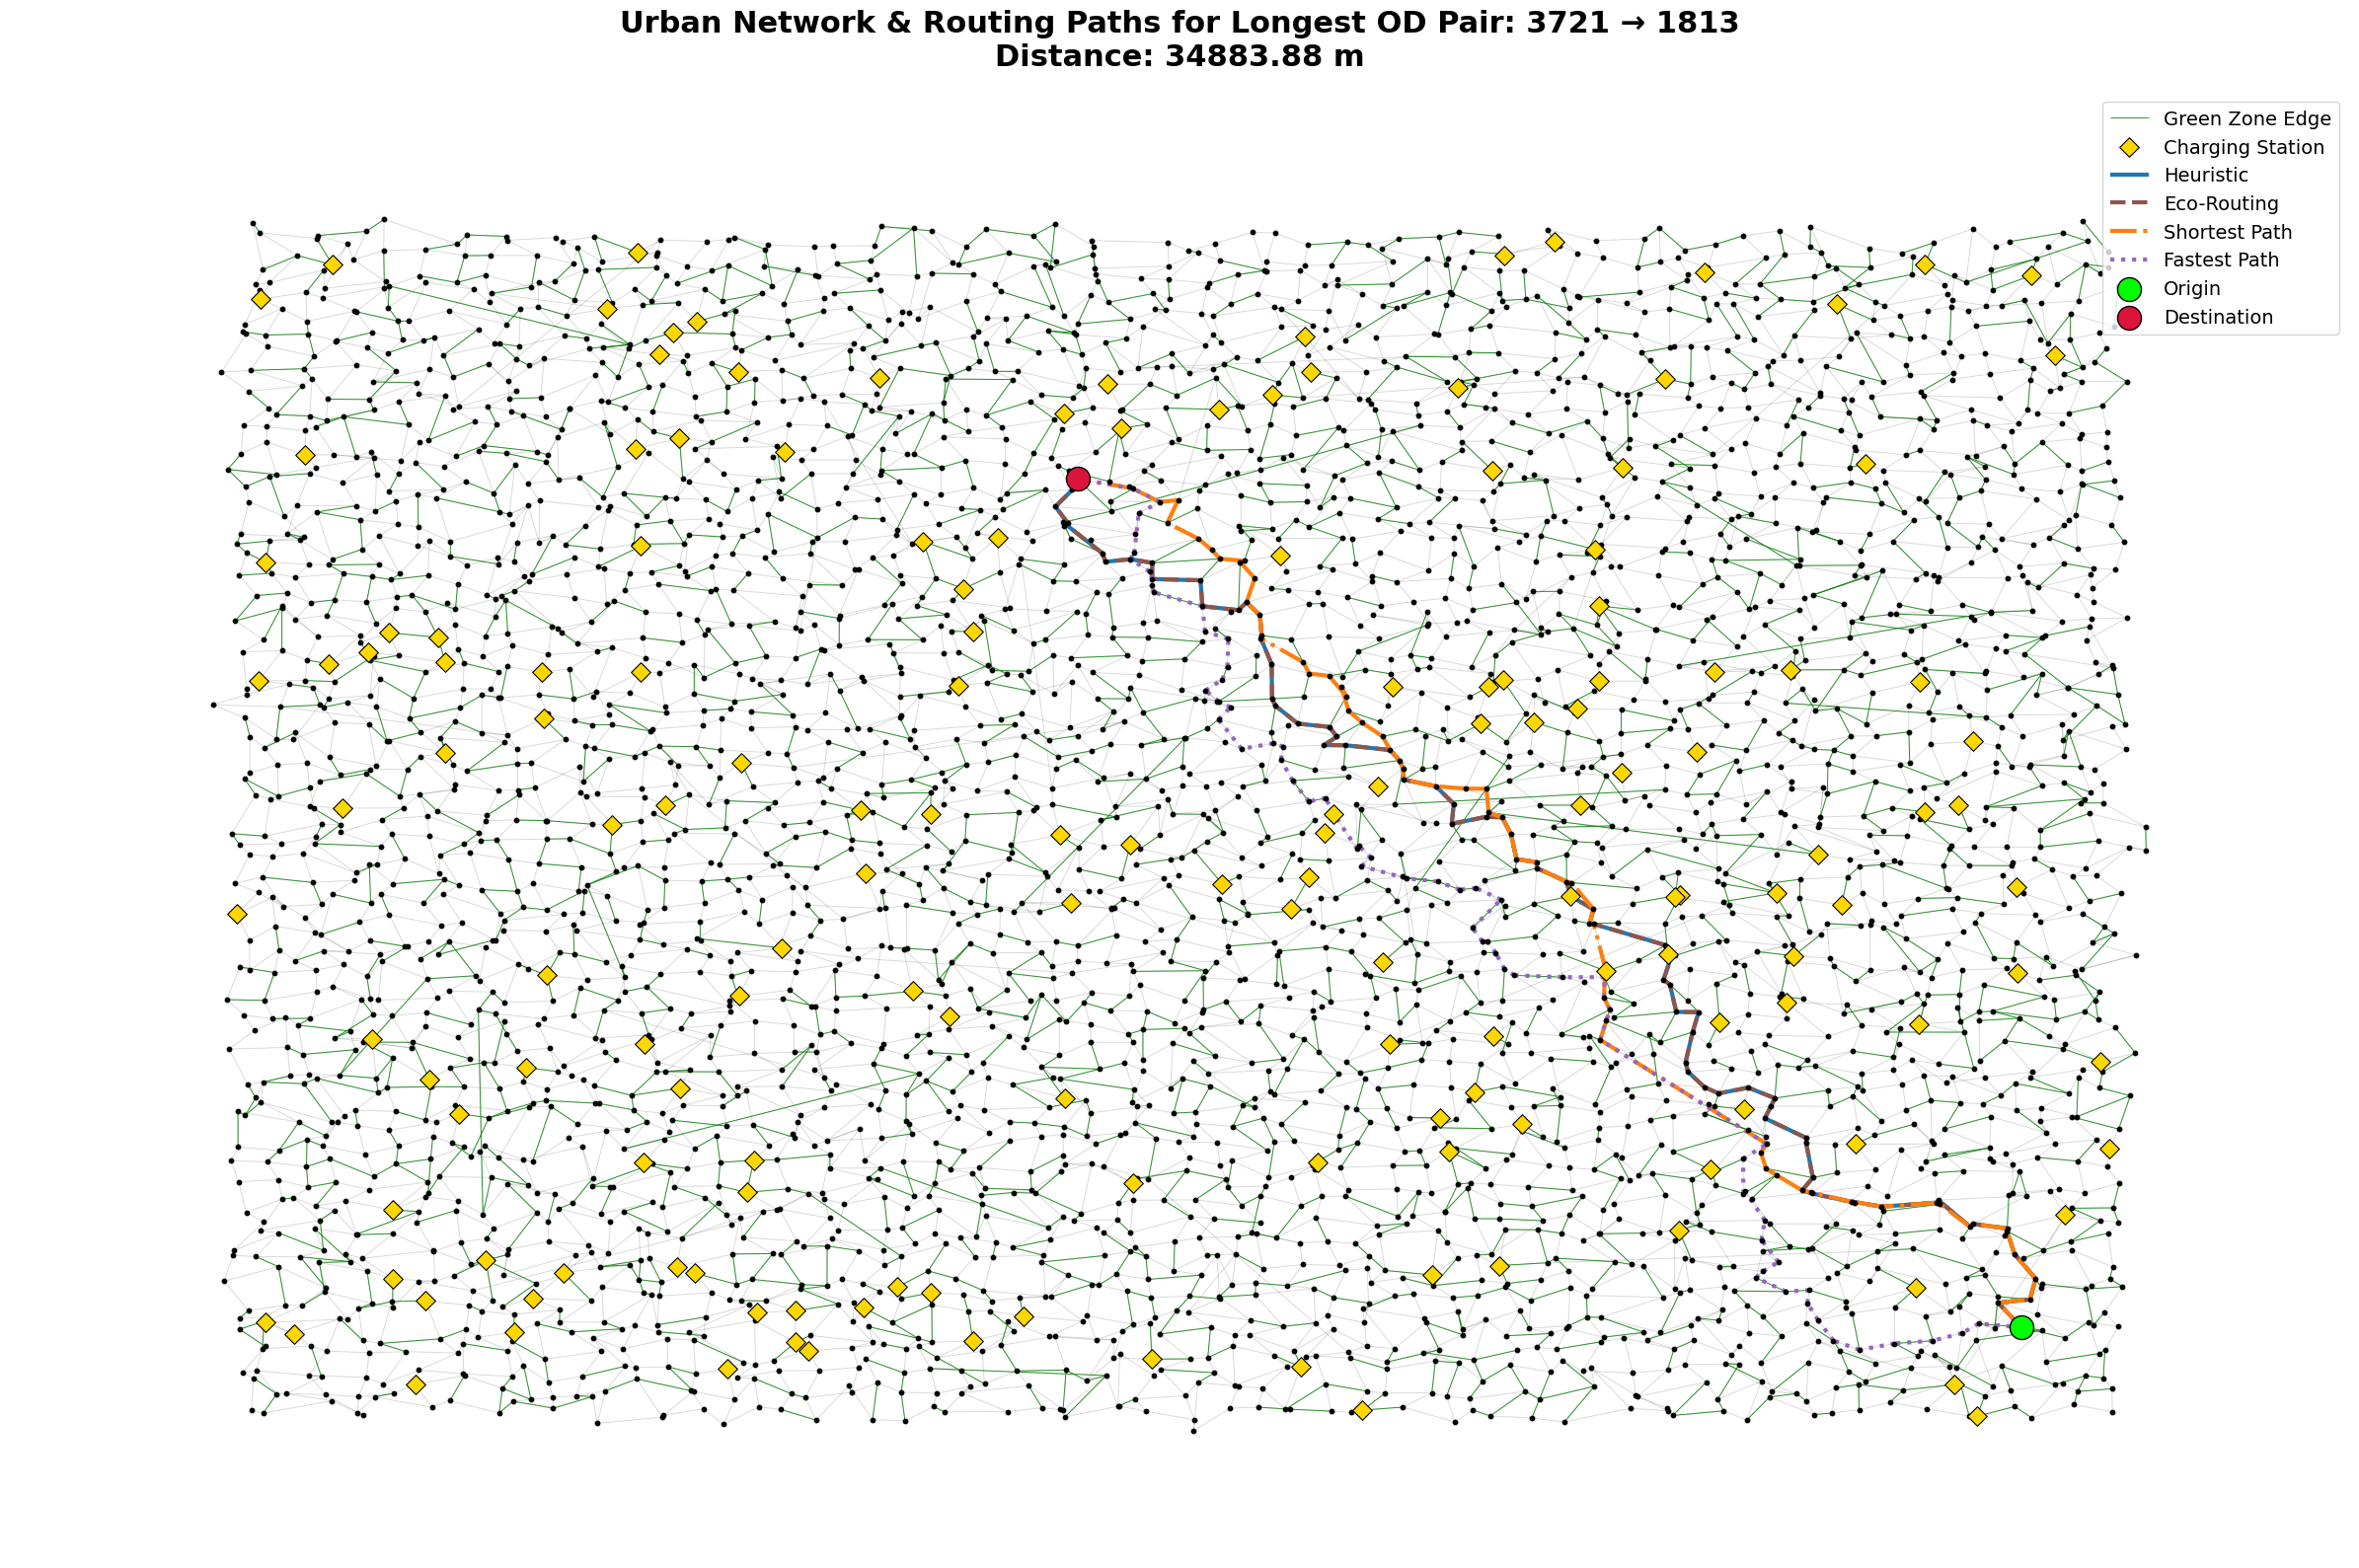

In [180]:
def visualize_longest_OD_improved(road_network, od_pairs):
    """
    Visualize the longest OD pair (based on Eco-Routing distance) on a 2D map, highlighting:
      - Green zone edges (in a brighter green with increased line width).
      - Charging stations (gold diamonds with black borders).
      - Four routing paths (Heuristic, Eco-Routing, Shortest Path, Fastest Path) in distinct colors & linestyles.
      - Origin (lime) and destination (crimson).

    The entire urban network is drawn in a light gray color with a low alpha to provide context.
    """

    import matplotlib.pyplot as plt
    import networkx as nx

    # Compute distance of a path
    def compute_path_distance(path, graph):
        return sum(graph[u][v]['length'] for u, v in zip(path[:-1], path[1:]))

    # 1. Find the longest OD pair
    max_distance = 0
    longest_pair = None
    for (origin, destination) in od_pairs:
        try:
            eco_path, _, _ = eco_routing_algorithm(road_network, origin, destination, VEHICLE_PARAMETERS)
            d = compute_path_distance(eco_path, road_network)
            if d > max_distance:
                max_distance = d
                longest_pair = (origin, destination)
        except:
            continue

    if longest_pair is None:
        print("No valid OD pair found for visualization.")
        return

    origin, destination = longest_pair
    print(f"Longest OD Pair: {origin} → {destination}, Distance: {max_distance:.2f} m")

    # 2. Run all four algorithms on the longest OD pair
    h_path, _, _ = heuristic_routing_algorithm(road_network, origin, destination, VEHICLE_PARAMETERS)
    e_path, _, _ = eco_routing_algorithm(road_network, origin, destination, VEHICLE_PARAMETERS)
    s_path, _, _ = shortest_path_distance(road_network, origin, destination, VEHICLE_PARAMETERS)
    f_path, _, _ = fastest_path_time(road_network, origin, destination, VEHICLE_PARAMETERS)

    # 3. Prepare data structures for plotting
    paths_dict = {
        "Heuristic": h_path,
        "Eco-Routing": e_path,
        "Shortest Path": s_path,
        "Fastest Path": f_path
    }

    route_colors = {
    "Heuristic": "#1f77b4",    # Classic blue
    "Eco-Routing": "#8c564b",  # Warm Brown
    "Shortest Path": "#ff7f0e",# Bold orange
    "Fastest Path": "#9467bd"  # Cool purple
    }

    route_styles = {
    "Heuristic": "solid",
    "Eco-Routing": "dashed",
    "Shortest Path": "dashdot",
    "Fastest Path": "dotted"
    }

    # Node positions
    pos = nx.get_node_attributes(road_network, 'pos')

    # 4. Create figure
    plt.figure(figsize=(24, 16))  # Larger figure for clarity
    ax = plt.gca()

    # Draw entire network edges in a light gray color, thin lines
    nx.draw_networkx_edges(
        road_network, pos,
        alpha=0.15, width=0.7, edge_color="black"
    )

    # Highlight green zone edges
    green_edges = [(u, v) for (u, v) in road_network.edges() if road_network[u][v].get('in_green_zone', False)]
    if green_edges:
        nx.draw_networkx_edges(
            road_network, pos, edgelist=green_edges,
            edge_color="green", width=0.7, alpha=0.8,
            label="Green Zone Edge"
        )

    # Draw nodes in a subtle color, small size
    nx.draw_networkx_nodes(
        road_network, pos,
        node_size=10, node_color="black"
    )

    # Charging stations (gold diamond, black border)
    charging_nodes = [n for n in road_network.nodes() if road_network.nodes[n].get('charging_station', False)]
    if charging_nodes:
        nx.draw_networkx_nodes(
            road_network, pos, nodelist=charging_nodes,
            node_color="gold", node_shape="D", node_size=100,
            edgecolors="black", linewidths=0.8,
            label="Charging Station"
        )

    # Overlay each route with distinct color & style
    for label, path in paths_dict.items():
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(
            road_network, pos, edgelist=path_edges,
            width=3, edge_color=route_colors[label],
            style=route_styles[label],
            label=label
        )

    # Mark origin and destination
    nx.draw_networkx_nodes(
        road_network, pos, nodelist=[origin],
        node_color="lime", node_size=300, edgecolors="black",
        linewidths=1.0, label="Origin"
    )
    nx.draw_networkx_nodes(
        road_network, pos, nodelist=[destination],
        node_color="crimson", node_size=300, edgecolors="black",
        linewidths=1.0, label="Destination"
    )

    # 5. Legend & title
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for h, l in zip(handles, labels):
        if l not in unique_labels:
            unique_labels.append(l)
            unique_handles.append(h)

    ax.legend(unique_handles, unique_labels, fontsize=14, loc="best", frameon=True)
    ax.set_title(
        f"Urban Network & Routing Paths for Longest OD Pair: {origin} → {destination}\nDistance: {max_distance:.2f} m",
        fontsize=22, fontweight="bold", pad=20
    )

    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Run the Visualization
visualize_longest_OD_improved(road_network, od_pairs)


===== Absolute Metrics (per OD Pair) =====
+-------------------------+----------------------------+-----------------------------+--------------------------+------------------------------+----------------------------+-----------------------------+--------------------------+------------------------------+
|         Metric          | ('Average', 'Eco-Routing') | ('Average', 'Fastest Path') | ('Average', 'Heuristic') | ('Average', 'Shortest Path') | ('Std Dev', 'Eco-Routing') | ('Std Dev', 'Fastest Path') | ('Std Dev', 'Heuristic') | ('Std Dev', 'Shortest Path') |
+-------------------------+----------------------------+-----------------------------+--------------------------+------------------------------+----------------------------+-----------------------------+--------------------------+------------------------------+
|  Energy Consumed (kWh)  |            1.5             |             2.0             |           1.3            |             1.61             |            0.52           

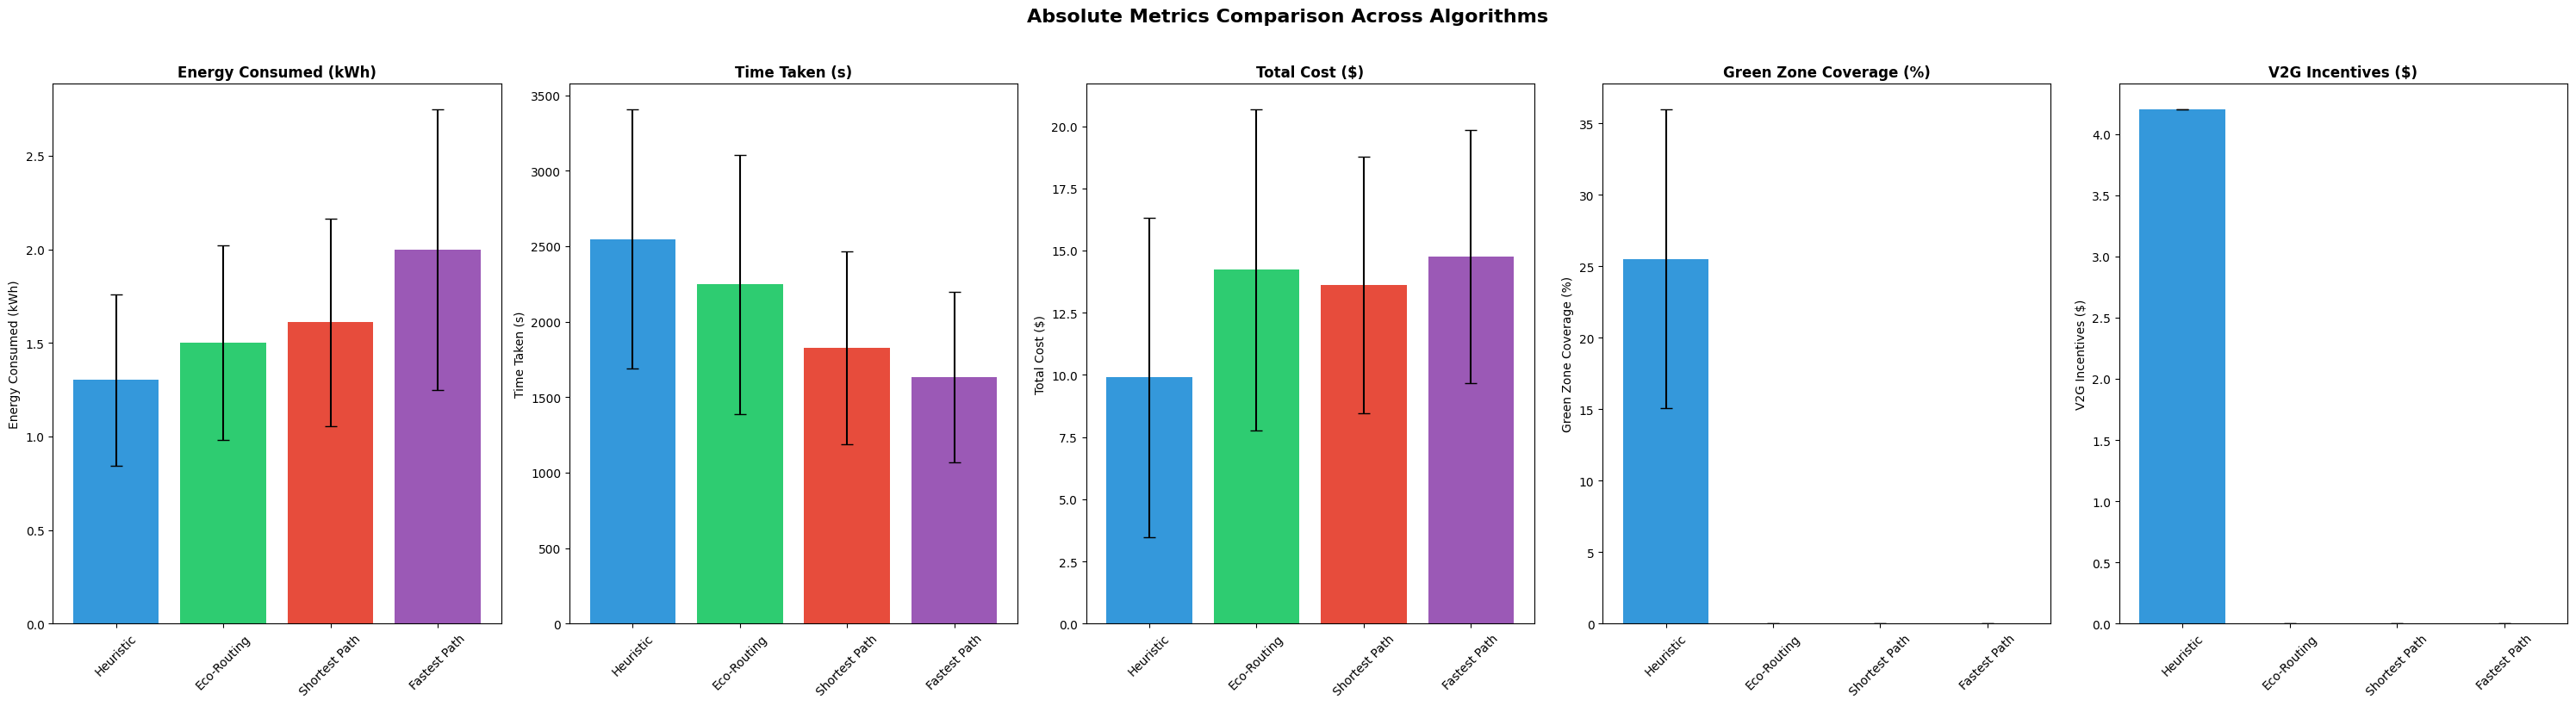

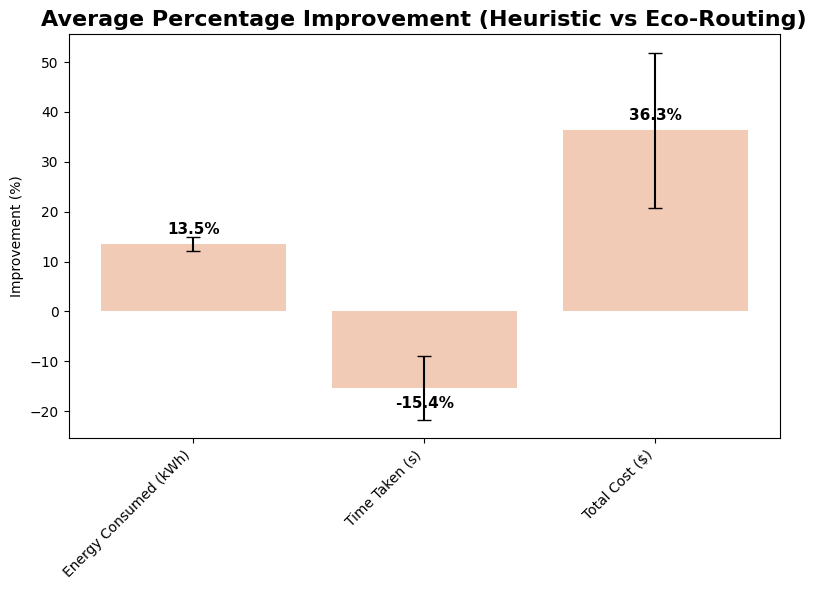

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Convert experiment results (list of dictionaries) into a DataFrame.
comp_df = pd.DataFrame(comp_results)

# Define the algorithms and their prefixes.
algo_keys = {'h': 'Heuristic', 'e': 'Eco-Routing', 's': 'Shortest Path', 'f': 'Fastest Path'}
algos = list(algo_keys.keys())

# Define the metrics to display in the absolute summary table.
abs_metrics = {
    'energy': 'Energy Consumed (kWh)',
    'time': 'Time Taken (s)',
    'cost': 'Total Cost ($)',
    'green_coverage': 'Green Zone Coverage (%)',
    'v2g_incentives': 'V2G Incentives ($)'
}
# Optionally include distance if available.
if 'h_distance' in comp_df.columns:
    abs_metrics['distance'] = 'Distance Travelled (m)'

# -----------------------------------------------------------------------------
# Part 1: Absolute Summary Table (mean ± std) for all algorithms
abs_summary = []
for metric_key, metric_label in abs_metrics.items():
    for algo in algos:
        col = f"{algo}_{metric_key}"
        if col in comp_df.columns:
            mean_val = comp_df[col].mean()
            std_val = comp_df[col].std()
            abs_summary.append({
                "Metric": metric_label,
                "Algorithm": algo_keys[algo],
                "Average": mean_val,
                "Std Dev": std_val
            })

abs_summary_df = pd.DataFrame(abs_summary)
abs_table = abs_summary_df.pivot(index="Metric", columns="Algorithm", values=["Average", "Std Dev"]).round(2)
print("===== Absolute Metrics (per OD Pair) =====")
print(tabulate(abs_table, headers="keys", tablefmt="pretty"))

# -----------------------------------------------------------------------------
# Part 2: Percentage Improvement (Heuristic vs Eco-Routing)
rel_metrics = {}
for metric_key, metric_label in abs_metrics.items():
    if metric_key in ['v2g_incentives', 'green_coverage']:
        continue  # Skip these metrics.
    if f"e_{metric_key}" in comp_df.columns and f"h_{metric_key}" in comp_df.columns:
        # For metrics where lower is better (energy, time, cost, distance), improvement = ((Eco - Heuristic)/Eco)*100.
        improvement = ((comp_df[f"e_{metric_key}"] - comp_df[f"h_{metric_key}"]) / comp_df[f"e_{metric_key}"].replace(0, 1)) * 100
        rel_metrics[metric_key] = improvement

# Build a summary table for percentage improvements.
rel_summary = []
for metric_key, metric_label in abs_metrics.items():
    if metric_key in rel_metrics:
        mean_impr = rel_metrics[metric_key].mean()
        std_impr = rel_metrics[metric_key].std()
        rel_summary.append({
            "Metric": metric_label + " Improvement (%)",
            "Heuristic vs Eco": f"{mean_impr:.2f} ± {std_impr:.2f}"
        })
rel_summary_df = pd.DataFrame(rel_summary)
print("\n===== Percentage Improvement (Heuristic vs Eco-Routing) =====")
print(tabulate(rel_summary_df, headers="keys", tablefmt="pretty"))

# -----------------------------------------------------------------------------
# Part 3: Graphs

# (A) Subplots for Absolute Metrics (one subplot per metric)
num_metrics = len(abs_metrics)
fig, axes = plt.subplots(1, num_metrics, figsize=(6*num_metrics, 8))
base_colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
for i, (metric_key, metric_label) in enumerate(abs_metrics.items()):
    ax = axes[i] if num_metrics > 1 else axes
    means = []
    stds = []
    labels = []
    for algo in algos:
        col = f"{algo}_{metric_key}"
        if col in comp_df.columns:
            means.append(comp_df[col].mean())
            stds.append(comp_df[col].std())
            labels.append(algo_keys[algo])
    x = np.arange(len(labels))
    c_slice = base_colors[:len(labels)]
    ax.bar(x, means, yerr=stds, capsize=5, color=c_slice)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title(metric_label, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_label)
plt.suptitle("Absolute Metrics Comparison Across Algorithms", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# (B) Single Bar Chart for Percentage Improvement (Heuristic vs Eco-Routing)
rel_summary_plot = []
for metric_key, metric_label in abs_metrics.items():
    if metric_key in rel_metrics:
        mean_impr = rel_metrics[metric_key].mean()
        std_impr = rel_metrics[metric_key].std()
        rel_summary_plot.append({
            "Metric": metric_label,
            "Average Improvement (%)": mean_impr,
            "Std Dev": std_impr
        })
rel_summary_plot_df = pd.DataFrame(rel_summary_plot)

plt.figure(figsize=(8,6))
ax = plt.gca()
color_val = plt.get_cmap("coolwarm")(0.6)
bars = ax.bar(rel_summary_plot_df["Metric"],
              rel_summary_plot_df["Average Improvement (%)"],
              yerr=rel_summary_plot_df["Std Dev"],
              capsize=5, color=color_val)
ax.set_title("Average Percentage Improvement (Heuristic vs Eco-Routing)", fontsize=16, fontweight='bold')
ax.set_ylabel("Improvement (%)")
ax.set_xlabel("")
plt.xticks(rotation=45, ha='right')

# Add numeric labels on top of each bar.
for idx, row in rel_summary_plot_df.iterrows():
    val = row["Average Improvement (%)"]
    ax.text(idx, val + (1.5 if val >= 0 else -1.5),
            f"{val:.1f}%", ha='center',
            va='bottom' if val >= 0 else 'top',
            fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()
